In [13]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
import torchvision.models as models
from torch.utils.data import DataLoader, random_split
from sklearn.metrics import accuracy_score, classification_report, confusion_matrix
from extract_images import TarImageDataset

file_path_fake = [f'../../data/wild_deepfake/fake_train/{i}.tar.gz' for i in range(1, 21)]
file_path_real = [f'../../data/wild_deepfake/real_train/{i}.tar.gz' for i in [1, 2, 4, 6, 11, 12, 13, 16, 17, 18, 19, 20]]
file_paths = file_path_fake + file_path_real

transform = None
data = TarImageDataset(file_paths, transform=transform)


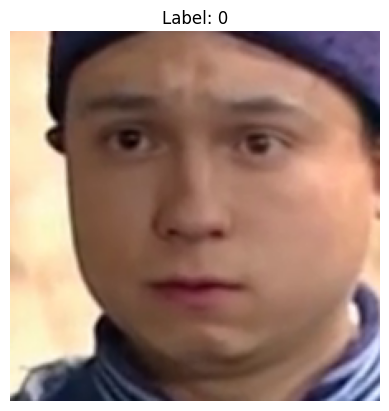

{0: 20419, 1: 16803}


In [14]:
image, label = data[1000]
if isinstance(image, torch.Tensor):
    image = image.permute(1, 2, 0).numpy()  # Convert from (C, H, W) to (H, W, C)
plt.imshow(image)
plt.title(f'Label: {label}')  # Show the label of the image
plt.axis('off')  # Turn off axis
plt.show()

print(data.get_label_distribution())

### Model training

In [15]:
# 1. Define the model
class MyModel(nn.Module):
    def __init__(self):
        super(MyModel, self).__init__()
        self.model = models.resnet18(pretrained=True)  # Using a pre-trained ResNet18 model
        self.model.fc = nn.Linear(self.model.fc.in_features, 2)  # Adjusting final layer for binary classification (real/fake)

    def forward(self, x):
        return self.model(x)

model = MyModel()

# 2. Define the data loaders
# Split dataset into training and validation sets
train_size = int(0.8 * len(data))  # 80% for training
val_size = len(data) - train_size   # 20% for validation
train_data, val_data = random_split(data, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_data, batch_size=32, shuffle=True)
val_loader = DataLoader(val_data, batch_size=32, shuffle=False)

c:\Users\KAI\anaconda3\envs\TP\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\KAI\anaconda3\envs\TP\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet18_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet18_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader

# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Define loss function and optimizer
criterion = nn.CrossEntropyLoss()  # For binary classification
optimizer = optim.Adam(model.parameters(), lr=0.001)

# Training loop
num_epochs = 10
for epoch in range(num_epochs):  # Corrected variable name from 'nume_pochs' to 'num_epochs'
    model.train()  # Set model to training mode
    running_loss = 0.0
    
    for images, labels in train_loader:
        images, labels = images.to(device), labels.to(device)  # Move data to GPU if available
        
        optimizer.zero_grad()  # Zero the parameter gradients
        outputs = model(images)  # Forward pass
        loss = criterion(outputs, labels)  # Calculate loss
        loss.backward()  # Backward pass
        optimizer.step()  # Optimize weights
        
        running_loss += loss.item()

    # Print epoch loss
    print(f'Epoch [{epoch + 1}/{num_epochs}], Loss: {running_loss / len(train_loader):.4f}')

    # Validation step
    model.eval()  # Set model to evaluation mode
    correct = 0
    total = 0
    with torch.no_grad():  # No gradient tracking for validation
        for images, labels in val_loader:
            images, labels = images.to(device), labels.to(device)
            outputs = model(images)
            _, predicted = torch.max(outputs.data, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    # Print validation accuracy
    print(f'Validation Accuracy: {100 * correct / total:.2f}%')

In [ ]:
torch.save(model.state_dict(), 'model.pth')

### Evaluation

In [16]:
# Initialize the model
model = MyModel()

# Step 2: Load the saved state dictionary
model.load_state_dict(torch.load('model.pth'))

# Assume your model, TarImageDataset, and necessary imports are already in place
test_file_path_fake = [f'../../data/wild_deepfake/fake_test/{i}.tar.gz' for i in range(1, 11)]
test_file_path_real = [f'../../data/wild_deepfake/real_test/{i}.tar.gz' for i in [3, 6, 8, 9]]
test_file_paths = test_file_path_fake + test_file_path_real

# Create the test dataset and DataLoader
test_dataset = TarImageDataset(test_file_paths, transform=transform)
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

C:\Users\KAI\AppData\Local\Temp\ipykernel_14664\2771694201.py:5: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load('model.pth'))


In [ ]:
# Set device to GPU if available
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model.to(device)

# Set model to evaluation mode
model.eval()

# Lists to store all predictions and true labels
all_preds = []
all_labels = []

# Disable gradient calculation
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)  # Move to device
        outputs = model(images)  # Forward pass
        _, predicted = torch.max(outputs.data, 1)  # Get the predicted class
        all_preds.extend(predicted.cpu().numpy())  # Store predictions
        all_labels.extend(labels.cpu().numpy())  # Store true labels

# Calculate and print the accuracy
accuracy = accuracy_score(all_labels, all_preds)
print(f'Test Accuracy: {accuracy:.2f}')

# Detailed classification report
print(classification_report(all_labels, all_preds, target_names=['Fake', 'Real']))
print(confusion_matrix(all_labels, all_preds))

Test Accuracy: 0.39
              precision    recall  f1-score   support

        Fake       0.78      0.40      0.53      8373
        Real       0.10      0.37      0.16      1509

    accuracy                           0.39      9882
   macro avg       0.44      0.38      0.34      9882
weighted avg       0.67      0.39      0.47      9882

[[3329 5044]
 [ 952  557]]
